PDFs files from micromobility companies were obtained which had information related to customer complaints regarding shared micromobility services. The PDF were not easily convertible to Excel spreadsheets and it had thousands of entries. The PDF were converted to excel sheets (for tabular and clear data) and text files. The text files were then preprocessed using RegEx in python to generate information. RegEx is used to search through the string data and recognize patterns and extract information from them.


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [287]:
#Functions used in all dataset procession:
#Standarizing the categories for comparision between companies
def standardize_category(category):
    category = category.lower()
    if category in ['malfunction', 'vandalism', 'damaged vehicle issues']:
        return 'Damaged Vehicle Issues'
    elif category in ['injury/accident','parking', 'driver behavior', 'irresponsible behavior', 'incidents']:
        return 'Incidents'
    elif category in ['refund', 'payments']:
        return 'Payments'
    elif category in [ 'other', 'General']:
        return 'Other'
    elif category in ['account/delete', 'account issues','app issues']:
        return 'Account Issues'
    elif category in ['trip issues', 'trips & fares','promotions']:
        return 'Trips & Fares'
    else:
        return 'Other'

### TEXT data 1

#### Preprocessing Data from TEXT_data_1

In [288]:
bird=pd.read_excel("Data/TEXT_data_1.xlsx")
bird=bird[bird.Particular.notna()]

In [289]:

#DATE: Assigning the date of the complaints to each complaint
bird['date'] = None
# List of months
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
#DATE: Compile a regex pattern to match month and year
month_pattern = "|".join(months)
date_pattern = re.compile(f"({month_pattern}) (\d{{4}})")
current_date = None
for index, row in bird.iterrows():
    match = date_pattern.search(row["Particular"])
    if match:
        current_date = f"{match.group(1)} {match.group(2)}"
    bird.at[index, 'date'] = current_date

#TYPE: Assigning measure of complaint such as time or number
bird['type']=None
bird.Values.replace({'               Time to remedy (min)':'Time to remedy',
'    Time to remedy (min)':'Time to remedy',
'Time to remedy (min)':'Time to remedy'})

value_types=['Number','Time to remedy']
current_type = None
for index, row in bird.iterrows():
    if row['Values'] in value_types:
        current_type = row['Values']
    bird.at[index, 'type'] =current_type

#SPLIT: some rows have multiple entries so seperating them and making seperate rows
def split_rows(row):
    particulars = str(row['Particular']).split('\n')
    values = str(row['Values']).split('\n')
    date = row['date']
    row_type = row['type']
    
    return [{'Particular': p, 'Values': v, 'date': date, 'type': row_type} for p, v in zip(particulars, values)]
# SPLIT: Apply the custom function to each row
split_rows_list = bird.apply(split_rows, axis=1)
flat_split_rows_list = [item for sublist in split_rows_list for item in sublist]
split_bird = pd.DataFrame(flat_split_rows_list)
bird=split_bird.reset_index(drop=True)
#CLEAN: cleaning "Values", renaming and deleting unwanted
condition=(bird.Values=='Time to remedy') | (bird.Values=='Number')| (bird.Values=='Number of Complaints') | (bird.Values=='    Time to remedy (min)')| (bird.Values=='               Time to remedy (min)') | (bird.Values==' Time to remedy (min)') | (bird.Values.isna())| (bird.Values=='nan')
bird=bird[~condition]
bird.Values=bird.Values.replace({'Immediately marked damage': '0',
'Immediate damage mark':'0',
'Auto-resolved (<2 hours)':'0',
'Ongoing conversation':'-1',
'Ongoing discussion':'-1'
})
#CLEAN: Custom function to extract the numeric values and convert every time related values to minutes
def extract_minutes(value):
    value = str(value).replace('gours', 'hours')
    match = re.search(r'(\d+(\.\d+)?)\s?(min|hours|minutes)?', str(value))
    if match:
        number = float(match.group(1))
        unit = match.group(3)
        if unit == 'hours':
            return number * 60
        else:
            return number
    else:
        return None
#CLEAN: Apply the custom function to the 'Values' column
bird.loc[(bird.type=='Time to remedy', 'Values')]= bird.loc[(bird.type=='Time to remedy', 'Values')].apply(extract_minutes)

#Deleting total complaints type rows
bird=bird[~(bird['Particular'].str.contains('Total'))]

In [290]:
#Aggregading the complaints into 8 types of complaints:
bird['Category']=None
complaint_categories = {
    'Parking': ['no parking zone'],
    'Malfunction': ['charger behavior','chargers','malfunction', 'vehicle issue', 'Vehicle underwater', 'underwater','Submerged Vehicle', 'vehicle(s) in water'],
    'Driver Behavior': ['driver behavior', 'Charger/driver behavior'],
    'Refund': ['Request for refund', 'Payment', 'payment'],
    'Injury/Accident': ['injury', 'accident', 'Fall/Rider', 'Rider fall'],
    'Irresponsible Behavior': ['irresponsible rider behavior', 'Improper', 'improper'],
    'Account/Delete': ['Request to delete account'],
    'Vandalism': ['Vandalism', 'Vadalism','private property','Reduced speed area','Fraudulent behavior','damage to property' ],
    'Others': []
}

# Custom function to map a complaint to its corresponding category
def map_complaint_to_category(complaint):
    for category, keywords in complaint_categories.items():
        for keyword in keywords:
            if keyword.lower() in complaint.lower():
                return category
    return 'Others'

# Apply the custom function to the 'Particular' column
bird['Category'] = bird['Particular'].apply(map_complaint_to_category)

In [291]:
#bird.to_csv("Data/TEXT_data_1_preprocessed.csv")

#### Text_data_1 EDA

In [292]:
sns.set_palette('Set2')

In [293]:
bird_df=bird.copy(deep=True)
from datetime import datetime
#Treating dtype of columns
bird_df['date'] = bird_df['date'].apply(lambda x: datetime.strptime(x, '%B %Y'))
bird_df['date'] = pd.to_datetime(bird_df['date'])
bird_df.Values=bird_df.Values.astype('int64')
bird_df.Category=bird_df.Category.astype('category')

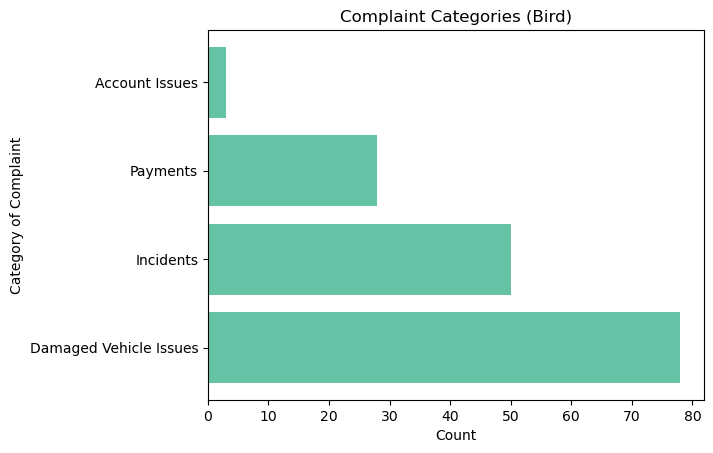

In [294]:
bird_df = bird_df.copy()
bird_df['categories_standard'] = bird_df['Category'].apply(standardize_category)
category_counts = bird_df['categories_standard'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Complaint Categories (Bird)')
plt.xlabel('Count')
plt.ylabel('Category of Complaint')
plt.savefig('plots/plot1_complaints_bird_standarized.png')
plt.show()

In [295]:
#Converting time values into number of complaints. One for each row
bird_df_numbers=bird_df.copy(deep=True)
bird_df_numbers.loc[(bird_df_numbers.type=='Time to remedy'), 'Values']=1
#Only working with time for remedy
bird_df_time=bird_df.copy(deep=True)
bird_df_time=bird_df_time[(bird_df_time.type=='Time to remedy')]

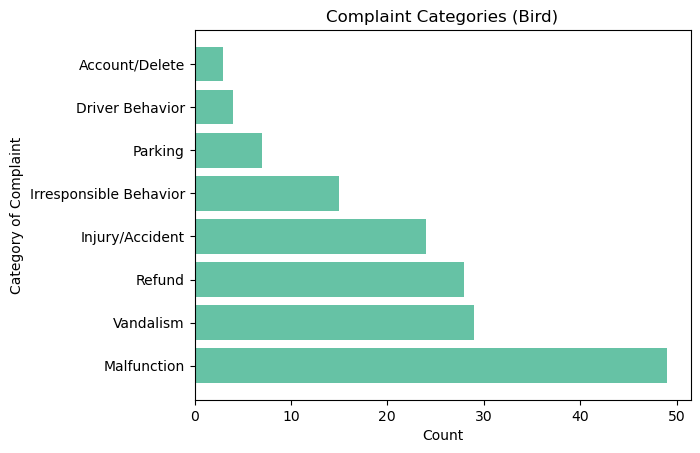

In [296]:
category_counts = bird_df['Category'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Complaint Categories (Bird)')
plt.xlabel('Count')
plt.ylabel('Category of Complaint')
plt.savefig('plots/plot2_complaints_bird.png')
plt.show()

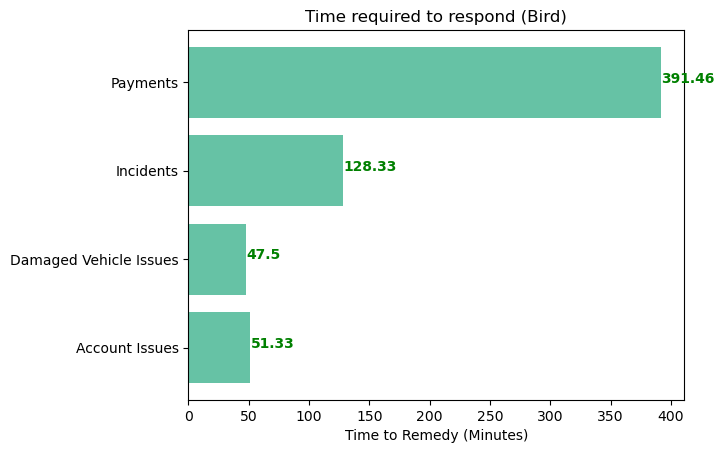

In [297]:
#Finding average
grouped_for_avg_time=bird_df_time.groupby(['categories_standard'], as_index=False)['Values'].mean()
#Plotting
plt.barh(grouped_for_avg_time.categories_standard, grouped_for_avg_time.Values)
plt.title('Time required to respond (Bird)')
plt.xlabel('Time to Remedy (Minutes)')
for i, v in enumerate(grouped_for_avg_time['Values']):
    plt.text(v + 0.5, i, str(round(v, 2)), color='green', fontweight='bold')
plt.savefig('plots/plot3_time_to_remedy_bird_standarized.png')
plt.show()

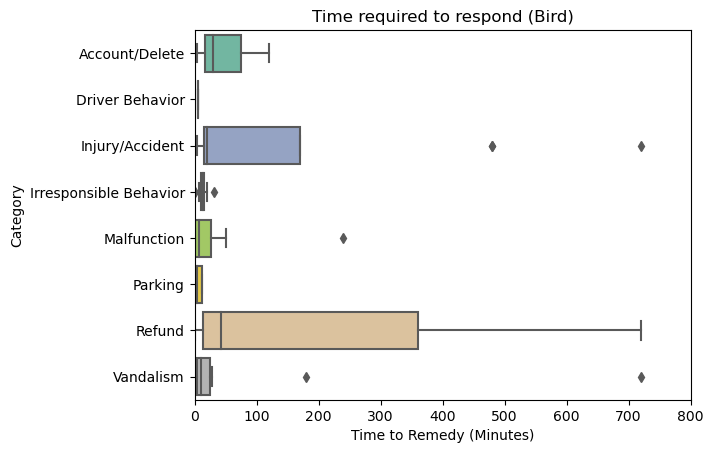

In [298]:

sns.boxplot(data=bird_df_time, x='Values', y='Category', orient='h')
plt.title('Time required to respond (Bird)')
plt.xlabel('Time to Remedy (Minutes)')
plt.xlim(0, 800)
plt.savefig('plots/plot4_time_to_remedy_bird.png')
plt.show()

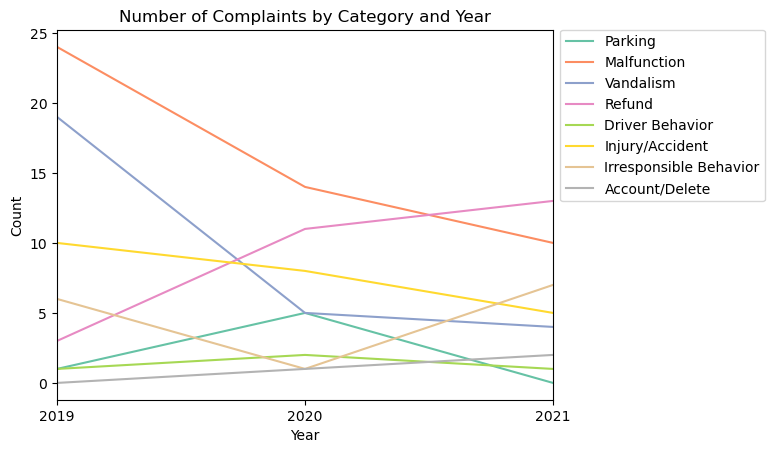

In [299]:
bird_df['Year'] = bird_df['date'].dt.year
bird_df_=bird_df[bird_df.Year!=2022] #Avoiding 2022 as we dont have complete data from 2022
# group the DataFrame by category and year, and count the number of complaints
grouped = bird_df_.groupby(['Category', 'Year']).size().reset_index(name='Count')

# create a line plot for each category of complaint
categories = bird_df_['Category'].unique()

for category in categories:
    category_data = grouped[grouped['Category'] == category]
    plt.plot(category_data['Year'], category_data['Count'], label=category)
plt.xlim(2019, 2021)
plt.xticks([2019, 2020, 2021], ['2019', '2020', '2021'])
# set the plot title and labels
plt.title('Number of Complaints by Category and Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

plt.savefig('plots/plot5_complaints_time_series.png')
# display the plot
plt.show()

### TEXT_data_2

#### Preprocessing data from TEXT_data_2

In [ ]:
lime_1=pd.read_excel("Data/TEXT_data_2_1.xlsx")

In [301]:
lime=lime_1.copy(deep=True)
#INIT
lime=lime.astype(str)
lime=lime.replace('nan', '')

#JOIN: The rows are broken so joining them based on date. One entry has a single date.
for i, row in lime.iterrows():
    # if the "month" column is empty and the previous row had data
    if (row['month']=='') and i > 0 and pd.notna(lime.loc[i-1, 'month']):
        # concatenate the values in the "value" column with the previous row
        lime.loc[i-1, 'subject'] += ' ' + row['subject']
        lime.loc[i-1, 'category'] += row['category']
        lime.loc[i-1, 'start_lat'] += row['start_lat']
        lime.loc[i-1, 'start_lon'] += row['start_lon']
        lime.loc[i-1, 'end_lat'] += row['end_lat']
        lime.loc[i-1, 'end_lon'] += row['end_lon']

# drop the rows where the "month" column is empty
lime = lime[lime['month']!='']

#CLEAN: category. 1st define key words for each category then mask and replace.
#personal_injury_/fatality
personal_words = ['incident', 'personal', 'injury', 'fatality', 'personal_in', 'personal_injury_/fatality']
mask = lime['category'].str.contains('|'.join(personal_words))
lime.loc[mask, 'category'] = 'personal_injury_/fatality'

#CLEAN: date and end_lon
lime['month'] = lime['month'].str.split().str[0]
lime['end_lon'] = lime['end_lon'].str.split().str[0]

#DATATYPE:
lime['start_lat'] = lime['start_lat'].replace('', None).str.replace('‐', '-').astype(float)
lime['start_lon'] = lime['start_lon'].replace('', None).str.replace('‐', '-').astype(float)
lime['end_lat'] = lime['end_lat'].replace('', None).str.replace('‐', '-').astype(float)
lime['end_lon'] = lime['end_lon'].replace('', None).str.replace('‐', '-').astype(float)

Example text <br>
9/1/2021 Austin Become a juicer
account_/_profile__l
ogin_issues 8541
9/1/2021 Austin
Wonâ€™t let me sign
up
account_/_profile__l
ogin_issues 1795

In [302]:
import pandas as pd
import re

def extract_text(lines):
    # Initialize variables
    data = []
    temp_text = ''
    date=''
    # Iterate through lines
    for line in lines:
        date_match = re.match(r'\d{1,2}/\d{1,2}/\d{4}', line)
        if date_match:
            if temp_text:
                data.append([date, temp_text.strip()])
                temp_text = ''
            date = date_match.group()
        else:
            temp_text += ' ' + line.strip()
    # Add the last entry
    if temp_text:
        data.append([date, temp_text.strip()])
    # Create a DataFrame with the data
    df = pd.DataFrame(data, columns=['date', 'text'])
    return(df)
# Read the text files
with open("Data/Lime/TEXT_data_2_2.txt", "r") as f:
    lines = f.readlines()
df1=extract_text(lines)
with open("Data/Lime/TEXT_data_2_3.txt", "r") as f:
    lines = f.readlines()
df2=extract_text(lines)

In [303]:
df=pd.concat([df1,df2]).reset_index(drop=True)

In [304]:
def extract_category(text):
    matches = re.findall(r'\w+/\w+|\w+_\w+', text)
    return ''.join(matches)

def extract_coordinates(text):
    coordinates = re.findall(r'\d+\.\d+', text)
    latitudes = [coord for coord in coordinates if coord.startswith('3')]
    longitudes = [coord for coord in coordinates if coord.startswith('9')]
    start_lat = latitudes[0] if len(latitudes) > 0 else None
    start_lon = longitudes[0] if len(longitudes) > 0 else None
    end_lat = latitudes[1] if len(latitudes) > 1 else None
    end_lon = longitudes[1] if len(longitudes) > 1 else None

    return start_lat, start_lon, end_lat, end_lon
# Apply the category extraction function
df['category'] = df['text'].apply(extract_category)
# Apply the coordinates extraction function and create new columns
df[['start_lat', 'start_lon', 'end_lat', 'end_lon']] = df.apply(lambda row: pd.Series(extract_coordinates(row['text'])), axis=1)

In [305]:
# Define a mapping dictionary to aggregate unique categories into common categories
category_mapping = {
    'account_/_profile__login_issues': 'Account Issues',
    'account/profile__change_account_/_bank': 'Account Issues',
    'account/profile__deleting_account': 'Account Issues',
    'app_issue__app_issue_/_app_unresponsi': 'App Issues',
    'cannot_end_trip_/_lock_vehicle__parking': 'Trip Issues',
    'cannot_end_trip/lock_vehicle___app_bu': 'Trip Issues',
    'cannot_end_trip/lock_vehicle___nolock_': 'Trip Issues',
    'cannot_end_trip/lock_vehicle___not_enough_details': 'Trip Issues',
    'cannot_start_trip__approval_issue': 'Trip Issues',
    'cannot_unlock_vehicle___app_issue': 'App Issues',
    '9/02cannot_unlock_vehicle___app_issue': 'App Issues',
    'cannot_unlock_vehicle__not_enough_det': 'Trip Issues',
    'damaged_vehicle__b': 'Damaged Vehicle Issues',
    'damaged_vehicle__brake_issue_': 'Damaged Vehicle Issues',
    'damaged_vehicle__broken_baseboard': 'Damaged Vehicle Issues',
    'damaged_vehicle__broken_handlebar': 'Damaged Vehicle Issues',
    'damaged_vehicle__k': 'Damaged Vehicle Issues',
    'damaged_vehicle__missing_/_gps_issue': 'Damaged Vehicle Issues',
    'damaged_vehicle__not_enough_informati': 'Damaged Vehicle Issues',
    'damaged/notdamaged_vehicle__not_enough_informati': 'Damaged Vehicle Issues',
    'damaged_vehicle__physical_lock_issue': 'Damaged Vehicle Issues',
    'damaged_vehicle__throttle/accelerator': 'Damaged Vehicle Issues',
    'damaged_vehicle__wheel_issues': 'Damaged Vehicle Issues',
    'damaged_vehicle__won_t_charge__charger_ok_': 'Damaged Vehicle Issues',
    'general__feedback': 'General',
    'general__inquiries_related_to_lime': 'General',
    'general__non_lime_related_/_spam': 'General',
    'general__wrong_number_/_disconnected_call_/_empty_tick': 'General',
    'incident__damage_to_private_property': 'Incidents',
    'incident__inappropriate_use__dangerous': 'Incidents',
    'incident__inappropriate_use__other': 'Incidents',
    'incident__police_/_gov_reporting_improper_vehicle_location': 'Incidents',
    'handlebar/missingincident__police_/_gov_reporting_improper_vehicle_location': 'Incidents',
    'incident__user_reporting_improper_vehicle_location': 'Incidents',
    'payments_/_balance__taxation_/_employment_condition_related_inquiry': 'Payments',
    'payments/balance__settle_arrears': 'Payments',
    'payments/balance__temporary/authorization_hold': 'Payments',
    'promotions__lime_a': 'Promotions',
    'promotions__promo_code_/_referral_coupon_issue': 'Promotions',
    'promotions__revoked_ridepass_limeprim': 'Promotions',
    'promotions__ridepass_limeprime_related': 'Promotions',
    'refunds__incorrect_refund_received': 'Refunds',
    '7/2refunds__incorrect_refund_received': 'Refunds',
    '9/189/19refunds__incorrect_refund_received': 'Refunds',
    'IMG_9625refunds__incorrect_refund_received': 'Refunds',
    'refunds__lime_wallet_refund_request': 'Refunds',
    'purchase/srefunds__lime_wallet_refund_request': 'Refunds',
    'trips_/_fares___vatnvoice_request': 'Trips & Fares',
    'trips_/_fares__resume_/_pause': 'Trips & Fares',
    'trips/fares__fines': 'Trips & Fares',
    'trips/fares__forgot_to_lock_vehicle': 'Trips & Fares',
    'trips/fares__group_riding_issue': 'Trips & Fares',
    '': 'Unknown'
}

# Replace the unique categories with more general categories
df['category'] = df['category'].apply(lambda x: category_mapping.get(x, 'Unknown'))
DF_lime=df[df.category!='Unknown']

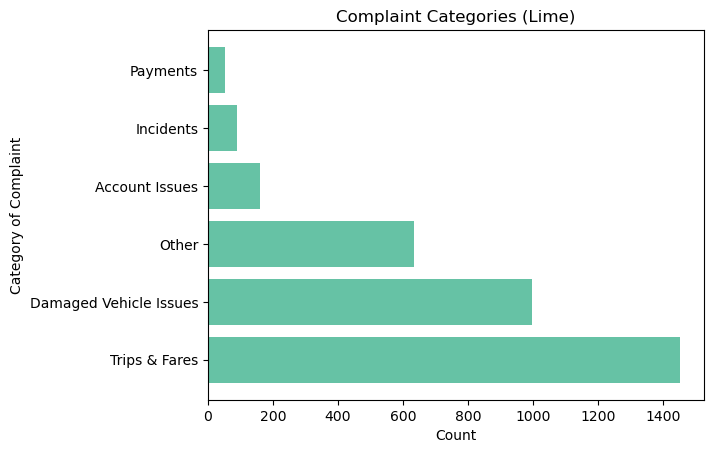

In [306]:
DF_lime = DF_lime.copy()
DF_lime['categories_standard'] = DF_lime['category'].apply(standardize_category)
category_counts = DF_lime['categories_standard'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Complaint Categories (Lime)')
plt.xlabel('Count')
plt.ylabel('Category of Complaint')
plt.savefig('plots/plot6_complaint_barplot_lime.png')
plt.show()

In [307]:
DF_lime.to_csv("Data/TEXT_data_2_preprocessed.csv", index=False)

### Superpedestrian

In [ ]:
#Sample Text:


In [308]:
import re
import pandas as pd

# Read the content of the txt file with 'ISO-8859-1' encoding and replace any invalid characters
with open('Data/Superpedestrian/TEXT_data_3.txt', 'r', encoding='ISO-8859-1', errors='replace') as file:
    data = file.read()

pattern = r'(?P<date>\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}\b)[\s\S]*?(?P<time>(?:\w*\b)?\d{1,2}:\d{2}:\d{2}\b)'

# Using the re.finditer() method to find all matches in the text
matches = re.finditer(pattern, data)

rows = []

# Looping through the matches
for match in matches:
    # Extracting the date, time, and text between them
    date = match.group('date')
    time = match.group('time')
    text_between = data[match.start('date') + len(date):match.start('time')].strip()

    rows.append({"Date": date, "Text": text_between, "Time": time})

# Create a pandas DataFrame using the 'rows' list
DF_sp = pd.DataFrame(rows)
#Cleaning the dataset (Text column)
DF_sp['Text'] = DF_sp['Text'].apply(lambda x: re.sub(r'^\d+', '', x).lstrip())
DF_sp['Text'] = DF_sp['Text'].apply(lambda x: re.sub(r'^\d+', '', x).lstrip()) #it only works if applied two times, dont know why. Notetoself: look into this

In [311]:
#Mapping and assigning standard categories
def standardize_complaint(text):
    text = text.lower()
    if re.search("damaged vehicle", text):
        return 'Damaged Vehicle Issues'
    elif re.search("app/ride", text) or re.search("signing in", text):
        return 'App Issues'
    elif re.search("billing", text) or re.search("refund", text) or re.search("credit / debit card not working", text):
        return 'Payments'
    elif re.search("trip", text) or re.search("fare", text):
        return 'Trips & Fares'
    elif re.search("parking concern", text):
        return 'Incidents'
    elif re.search("promotion", text):
        return 'Promotions'
    elif text == '':
        return 'Other'
    else:
        return 'Other'

DF_sp['categories_standard'] = DF_sp['Text'].apply(standardize_complaint)


In [312]:
DF_sp.to_csv("Data/TEXT_data_3_preprocessed.csv", index=False)

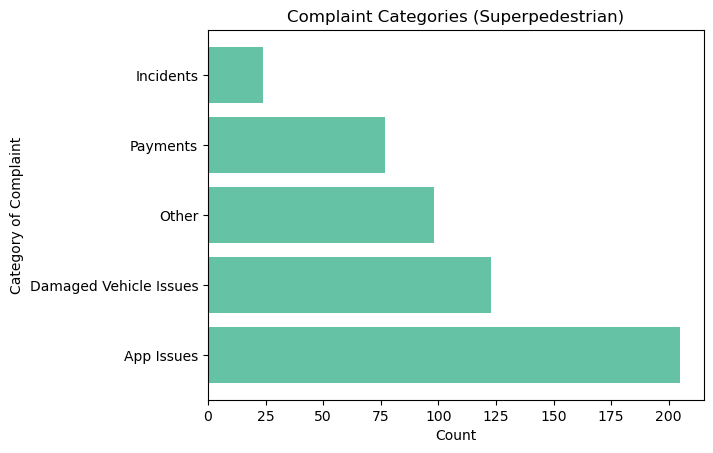

In [314]:

category_counts = DF_sp['categories_standard'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Complaint Categories (Superpedestrian)')
plt.xlabel('Count')
plt.ylabel('Category of Complaint')
plt.savefig('plots/plot7_complaint_barplot_sp.png')
plt.show()

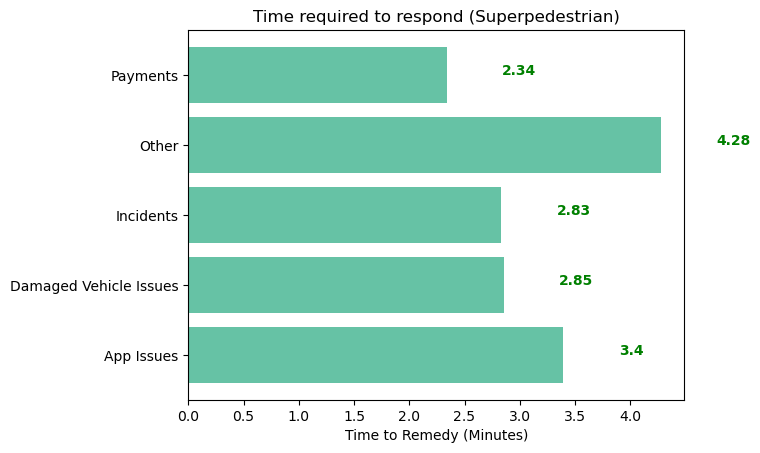

In [315]:
#processing time column
import datetime
def convert_to_minutes(time_str):
    delta_time = datetime.timedelta(hours=int(time_str.split(":")[0]),
                                    minutes=int(time_str.split(":")[1]),
                                    seconds=int(time_str.split(":")[2]))
    total_minutes = delta_time.total_seconds() // 60
    return total_minutes

# apply the conversion function to the column(s) containing time data
DF_sp['Time_min'] = DF_sp['Time'].apply(convert_to_minutes)
#Finding average
grouped_for_avg_time=DF_sp.groupby(['categories_standard'], as_index=False)['Time_min'].mean()
#Plotting
plt.barh(grouped_for_avg_time.categories_standard, grouped_for_avg_time.Time_min)
plt.title('Time required to respond (Superpedestrian)')
plt.xlabel('Time to Remedy (Minutes)')

for i, v in enumerate(grouped_for_avg_time['Time_min']):
    plt.text(v + 0.5, i, str(round(v, 2)), color='green', fontweight='bold')
plt.savefig('plots/plot8_time_to_remedy_sp.png')
plt.show()

#### Combined categories plot

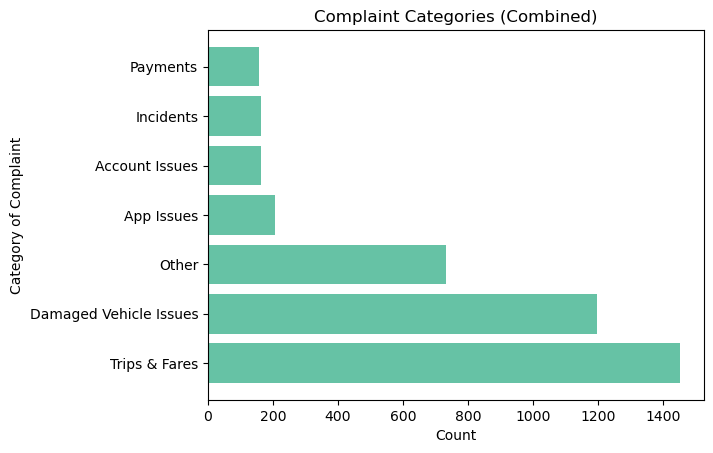

In [316]:
combined_df = pd.concat([DF_sp[[ 'categories_standard']],
                         DF_lime[['categories_standard']],
                         bird_df[['categories_standard']]])

category_counts = combined_df['categories_standard'].value_counts()
plt.barh(category_counts.index, category_counts.values)
plt.title('Complaint Categories (Combined)')
plt.xlabel('Count')
plt.ylabel('Category of Complaint')
plt.savefig('plots/plot9_complaint_barplot_combined.png')
plt.show()

### Note

In [317]:
# create the note as a string with bullet points
note = '''Note:
\n1. Here "other" category also includes unknown category
\n2. 
'''
# open a file in write mode and write the note to the file
with open('notes.txt', 'w') as f:
    f.write(note)
print("Note saved to 'notes.txt' file.")

Note saved to 'notes.txt' file.
